In [ ]:
%reload_ext juno_magic
%juno connect 
%juno list

In [293]:
%juno select io.timbr.kernel.95283e59-3680-42cf-b937-7eba27fa658a

No previous subscriptions
Kernel selected [io.timbr.kernel.95283e59-3680-42cf-b937-7eba27fa658a: Landsat Fire Indices]


In [214]:
%%juno

%reload_ext gist_magic
%gist preset 6b3bf9623221d6e507a58d3b68ea2eeb --no-display

In [216]:
%%juno

import json 
geojson = './modis_fire_2015.json'

if not os.path.exists(geojson):
    import urllib
    urllib.urlretrieve('https://raw.githubusercontent.com/chelm/geodata/master/modis_fire_2015_365_conus.json', geojson)

with open(geojson, 'r') as data:
    fires = json.loads(data.read())
    
display(HTML('<h2>%s MODIS Detected Fires in 2015</h2>' % len(fires['features'])))

In [217]:
%%juno

%matplotlib inline
import matplotlib.pyplot as plt
from dateutil import parser
import matplotlib.dates as mdates
import datetime

confs, temps, lons, lats, dates = [], [], [], [], []
for f in fires['features']:
    confs.append(int(f['properties']['CONF']))
    temps.append(float(f['properties']['TEMP']))
    lons.append(float(f['properties']['LONG']))
    lats.append(float(f['properties']['LAT']))
    dates.append(parser.parse(f['properties']['DATE']))

# Data Exploration

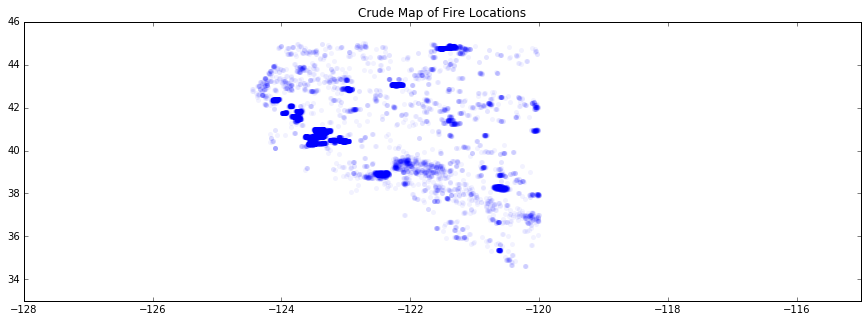

In [32]:
%%juno 

fig, ax = plt.subplots(1, figsize=(15,5))
plt.title('Crude Map of Fire Locations')
ax.set_ylim((33,46))
ax.set_xlim((-128,-115))
plt.scatter(lons, lats, s=25, marker='o', alpha=0.05, lw = 0)
plt.show()

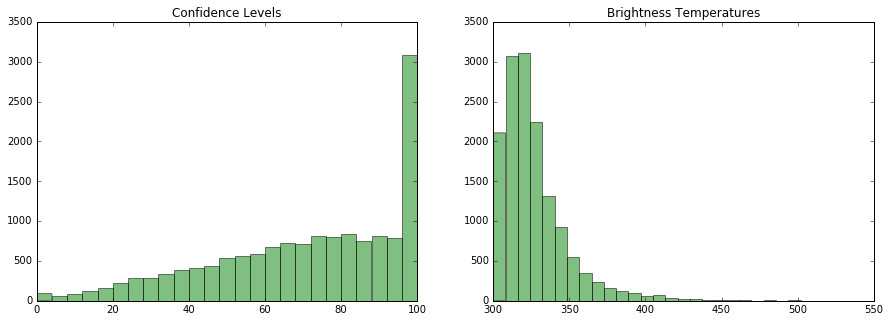

In [33]:
%%juno

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.set_title('Confidence Levels')
ax1.hist(confs, bins=25, alpha=.5, color='green')
ax2.set_title('Brightness Temperatures')
ax2.hist(temps, bins=25, alpha=.5, color='green')
plt.show()

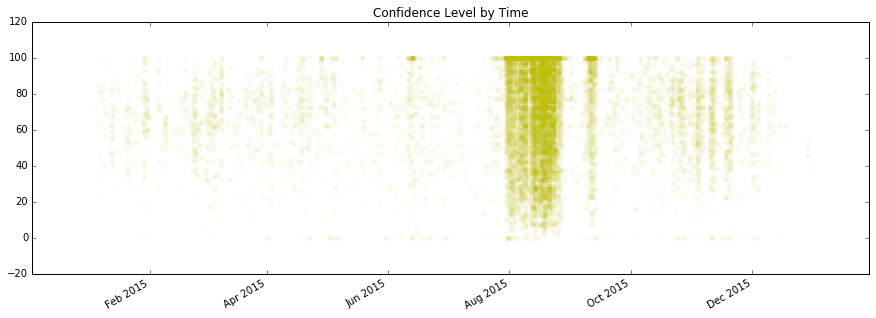

In [34]:
%%juno

fig, ax = plt.subplots(1, figsize=(15,5))
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

plt.title('Confidence Level by Time')
plt.scatter(dates, confs, s=25, color='y', marker='o', alpha=0.05, lw = 0)
plt.show()

In [299]:
%%juno


fig, ax = plt.subplots(1, figsize=(15,5))
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

plt.title('Brightness Temperatures by Time')
plt.scatter(dates, temps, s=25, color='g', marker='o', alpha=0.05, lw = 0)
plt.show()

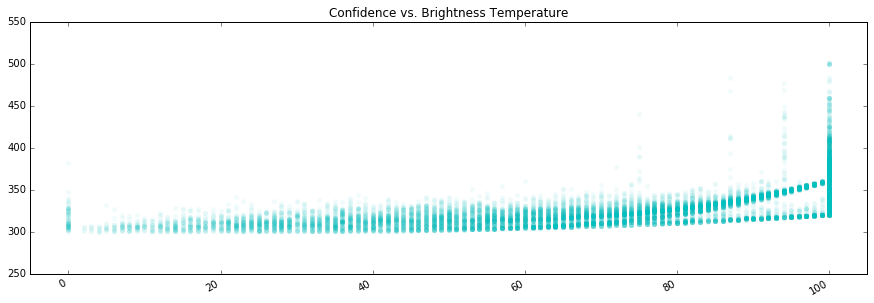

In [36]:
%%juno 

fig, ax = plt.subplots(1, figsize=(15,5))
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_xlim(-5, 105)
plt.title('Confidence vs. Brightness Temperature')
plt.scatter(confs, temps, s=25, color='c', marker='o', alpha=0.05, lw = 0)
plt.show()

# Site Suitability

Before we can run our an analysis for a fire location we need to determine which sites, if any, have suitable Landsat data. For our use case here a "suitable" area is primarily determined by the presence of one image before and one image after the fire. In order to test this we issue a search for each fire event, and test the suitability of the results.

In [219]:
%%juno

# Filters 
confidence_low = 90
temperature_low = 400


filtered = []
for f in fires['features']:
    props = f['properties']
    if props['CONF'] >= confidence_low and props['TEMP'] >= temperature_low:
        filtered.append(f)
        

display(HTML('<h2>%s Filtered Fire Events (Conf: %d, Temp: %d) </h2>' % (len(filtered), confidence_low, temperature_low)))

In [ ]:
from ipyleaflet import Map, GeoJSON, CircleMarker

(lon,lat),zoom = [-118, 40], 5
m = Map(center=[lat, lon], zoom=zoom)
g = GeoJSON(data={'features': [f for f in filtered] })
m.add_layer(g)
m

In [276]:
%%juno 

%gist 6e7e828e4d4696aca52beae8290f048c --evaluate

,
,pairs = []
,
,"def is_suitable(images, event, start, end):"
,""""""""
,Logic for determining if an area is 'suitable' or not for analysis.
,Compares images before and after and restrict suitable areas to unique combos of sceneIds
,""""""""
,global pairs
,"pre, post = [], []"
,for img in images:


In [279]:
%%juno

suitable = find_suitable_areas(filtered, is_suitable, days=50)
display(HTML('<h2>%s Suitable Areas Found</h2>' % str(len(suitable))))

# Normalized Burn Ratios

In [222]:
%%juno

# Compares pre/post burn indices 
def compare_indices(sceneId1, sceneId2, geometry, buff=0.05, cache=False, visual=True):
    pnt = shape(geometry)
    bbox = pnt.buffer(buff).bounds

    pre = create_index(sceneId1, 'NBR', bbox=bbox, use_cache=cache)
    post = create_index(sceneId2, 'NBR', bbox=bbox, use_cache=cache)
    
    if visual is True:
        pre_rgb = create_rgb(sceneId1, bbox=bbox, use_cache=cache)
        post_rgb = create_rgb(sceneId2, bbox=bbox, use_cache=cache)
    else:
        pre_rgb = None
        post_rgb = None
    
    try:
        diff = rescale_intensity(pre - post, out_range=(0,1))
    except:
        diff = None
        
    return {'visual': [pre_rgb, post_rgb],
            'indices': [pre, post],
            'difference': diff}

def render_indices(result):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,10))
    ax1.set_title('Before')
    ax1.imshow(result['indices'][0], cmap='Spectral_r')
    ax1.axis('off')

    ax2.set_title('After')
    ax2.imshow(result['indices'][1], cmap='Spectral_r')
    ax2.axis('off')

    ax3.set_title('Difference')
    ax3.imshow(result['difference'], cmap='Spectral_r')
    ax3.axis('off')
    plt.show()
    
def render_visual(result):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
    ax1.set_title('Before')
    ax1.imshow(result['visual'][0])
    ax1.axis('off')

    ax2.set_title('After')
    ax2.imshow(result['visual'][1])
    ax2.axis('off')
    plt.show()


 Creating Color Corrected RGB for: LC80450322015199LGN00



 Creating Color Corrected RGB for: LC80450322015263LGN00


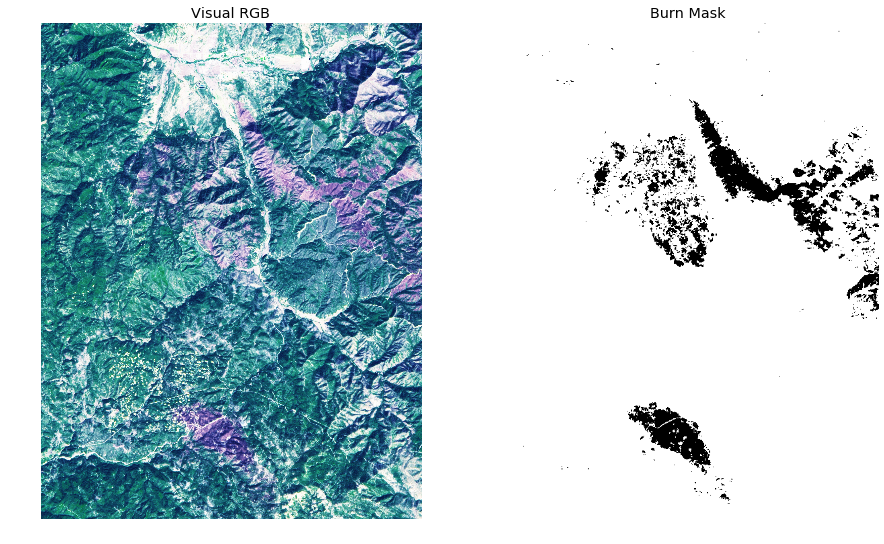

In [297]:
%%juno

## Look at the first area

area = suitable[11]
pre_meta = area['pre'][0]['properties']
post_meta = area['post'][0]['properties']
result = compare_indices(pre_meta['sceneID'], 
                         post_meta['sceneID'], 
                         area['feature']['geometry'], 
                         buff=0.1, 
                         visual=True)




# Create a Burn Mask
diff = result['difference'].copy()
idx = diff > 0.5
diff[ idx ] = 1
diff[ ~idx ] = 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.set_title('Visual RGB')
ax1.imshow(result['visual'][1])
ax1.axis('off')

ax2.set_title('Burn Mask')
ax2.imshow(diff, cmap='Greys')
ax2.axis('off')
plt.show()

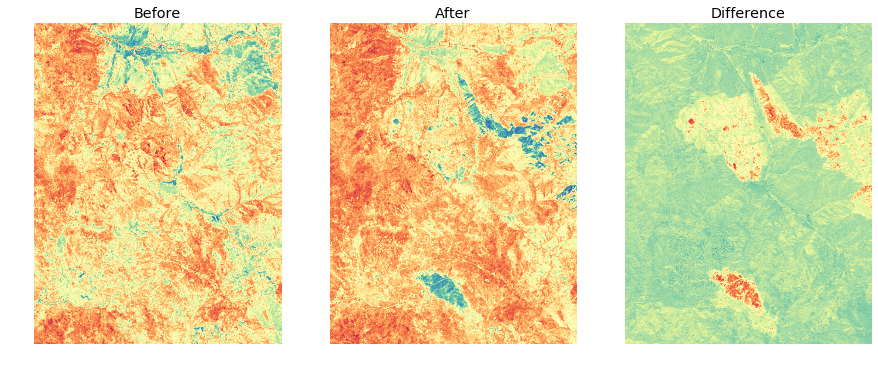

In [298]:
%%juno
render_indices(result)

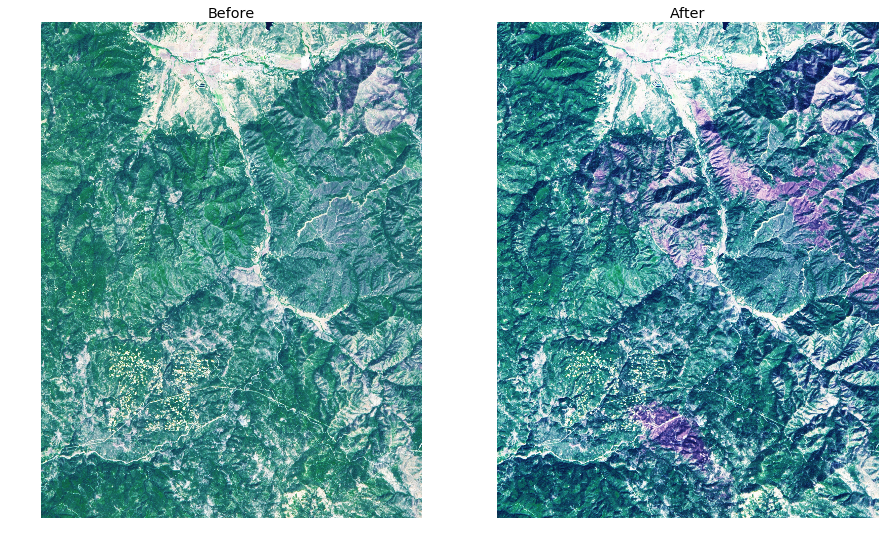

In [295]:
%%juno
render_visual(result)


# Burn Area Analysis 

In [ ]:
%%juno

burnt_areas = []

for i, area in enumerate(suitable):
    try: 
        pre_meta = area['pre'][0]['properties']
        post_meta = area['post'][0]['properties']
        result = compare_indices(pre_meta['sceneID'], 
                                 post_meta['sceneID'], 
                                 area['feature']['geometry'], 
                                 buff=0.1, 
                                 visual=False, 
                                 cache=False)

        if result['difference'] is not None:
            print 'Burn Area:', i
            render_indices(result)
            diff = result['difference'].copy()
            idx = diff > 0.5
            diff[ idx ] = 1
            diff[ ~idx ] = 0

            sq_km = (np.count_nonzero(diff) * 30) / 1000
            #print area['feature']['geometry']['coordinates'], sq_km
            burnt_areas.append(sq_km)
    except:
        pass
    

# Results

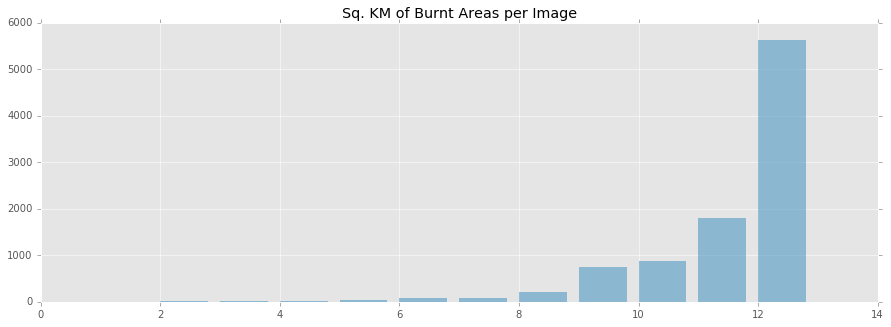

In [281]:
%%juno

plt.style.use('ggplot')

fig, ax = plt.subplots(1, figsize=(15,5))
plt.title('Sq. KM of Burnt Areas per Image')
ax.set_ylim((0,6000))
plt.bar(range(len(burnt_areas)), sorted(burnt_areas), alpha=0.5, lw = 0)
plt.show()